**Abstract**

The sudden increase in COVID-19 cases is putting high pressure on healthcare services worldwide. At this stage, fast, accurate and early clinical assessment of the disease severity is vital. To support decision making and logistical planning in healthcare systems, this study leverages a database of blood samples from 485 infected patients in the region of Wuhan, China, to identify crucial predictive biomarkers of disease mortality. For this purpose, **machine learning tools selected three biomarkers that predict the mortality of individual patients more than 10 days in advance with more than 90% accuracy: lactic dehydrogenase (LDH), lymphocyte and high-sensitivity C-reactive protein (hs-CRP)**. In particular, relatively high levels of LDH alone seem to play a crucial role in distinguishing the vast majority of cases that require immediate medical attention. This finding is consistent with current medical knowledge that high LDH levels are associated with tissue breakdown occurring in various diseases, including pulmonary disorders such as pneumonia. Overall, this Article suggests a simple and operable decision rule to quickly predict patients at the highest risk, allowing them to be prioritized and potentially reducing the mortality rate.

More: https://www.nature.com/articles/s42256-020-0180-7

Exercises
1. Split data into training and test sets.
2. Fit a RandomForestClassifier on the training set.
3. Evaluate the classifier performance by calculating the confusion matrix and the F1 score on the test set.
4. Plot the feature importances of the fitted classifier (this is basically the main finding of the Nature paper).
5. Try running a different type of classifier and/or see how well you can do on the test set by tuning hyperparameters using cross-validation, grid search or otherwise.

In [ ]:
import datetime
import pandas as pd

### **Training data**

The original training datasets for the paper are linked as supplementary data. You don't have to download this since we have included the single Excel file we need for this example as data/time_series_375_preprocess_en.xlsx in this project. Below we provide code to read the Excel data into a Pandas DataFrame.

In [ ]:
TRAIN_PATH = 'https://github.com/semacu/data-science-python/blob/master/data/time_series_375_preprocess_en.xlsx?raw=true'
RANDOM_SEED=42

In [40]:
#https://www.python.org/dev/peps/pep-0612/

def load_training_data(path: str) -> pd.DataFrame:
    """ 
    Load Excel sheet of measurements from patients (timepandas.DataFrame with MultiIndex ['PATIENT_ID', 'RE_DATE'] 
    (the unique patient identifier and patient sample date, corresponding to columns [0,1] respectively of the loaded worksheet), 
    then retain the last set of measurements made per patient, drop 'Admission time', 'Discharge time', 'gender' 
    and 'age' features, and replace NaNs with -1. 
    """

    # Specify explicitly what columns we want to load and what their data types are expected to be.
    DTYPES = {
        'PATIENT_ID': int,
        'RE_DATE': str,
        'age': int,
        'gender': int,
        'Admission time': str,
        'Discharge time': str,
        'outcome': float,
        'Hypersensitive cardiac troponinI': float,
        'hemoglobin': float,
        'Serum chloride': float,
        'Prothrombin time': float,
        'procalcitonin': float,
        'eosinophils(%)': float,
        'Interleukin 2 receptor': float,
        'Alkaline phosphatase': float,
        'albumin': float,
        'basophil(%)': float,
        'Interleukin 10': float,
        'Total bilirubin': float,
        'Platelet count': float,
        'monocytes(%)': float,
        'antithrombin': float,
        'Interleukin 8': float,
        'indirect bilirubin': float,
        'Red blood cell distribution width': float,
        'neutrophils(%)': float,
        'total protein': float,
        'Quantification of Treponema pallidum antibodies': float,
        'Prothrombin activity': float,
        'HBsAg': float,
        'mean corpuscular volume': float,
        'hematocrit': float,
        'White blood cell count': float,
        'Tumor necrosis factorα': float,
        'mean corpuscular hemoglobin concentration': float,
        'fibrinogen': float,
        'Interleukin 1β': float,
        'Urea': float,
        'lymphocyte count': float,
        'PH value': float,
        'Red blood cell count': float,
        'Eosinophil count': float,
        'Corrected calcium': float,
        'Serum potassium': float,
        'glucose': float,
        'neutrophils count': float,
        'Direct bilirubin': float,
        'Mean platelet volume': float,
        'ferritin': float,
        'RBC distribution width SD': float,
        'Thrombin time': float,
        '(%)lymphocyte': float,
        'HCV antibody quantification': float,
        'D-D dimer': float,
        'Total cholesterol': float,
        'aspartate aminotransferase': float,
        'Uric acid': float,
        'HCO3-': float,
        'calcium': float,
        'Amino-terminal brain natriuretic peptide precursor(NT-proBNP)': float,
        'Lactate dehydrogenase': float,
        'platelet large cell ratio ': float,
        'Interleukin 6': float,
        'Fibrin degradation products': float,
        'monocytes count': float,
        'PLT distribution width': float,
        'globulin': float,
        'γ-glutamyl transpeptidase': float,
        'International standard ratio': float,
        'basophil count(#)': float,
        '2019-nCoV nucleic acid detection': float,
        'mean corpuscular hemoglobin': float,
        'Activation of partial thromboplastin time': float,
        'High sensitivity C-reactive protein': float,
        'HIV antibody quantification': float,
        'serum sodium': float,
        'thrombocytocrit': float,
        'ESR': float,
        'glutamic-pyruvic transaminase': float,
        'eGFR': float,
        'creatinine': float
    }

    # Specify which string columns should be interpreted as datetimes.
    DATETIME_COLUMNS = ['RE_DATE', 'Admission time', 'Discharge time']
    
    return (
        pd.read_excel(path, index_col=[0,1], dtype=DTYPES, parse_dates=DATETIME_COLUMNS)
            .sort_index()
            .groupby('PATIENT_ID').last()
            .drop(['Admission time', 'Discharge time'], axis=1)
            .drop(['age', 'gender'], axis=1) # removed in later preprocessing step in original paper       
    )

In [ ]:
def remove_columns_with_missing_data(df: pd.DataFrame, 
                                     threshold: float=0.2) -> pd.DataFrame:
    """ 
    Remove all columns from DataFrame df where the proportion 
    of missing records is greater than threshold.
    """
    return df.dropna(axis=1, thresh=(1.0-threshold)*len(df))

In [ ]:
data = load_training_data(path=TRAIN_PATH)
print(data.shape)
data.head()

(375, 75)


,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,19.9,131.0,100.0,12.4,0.09,1.7,NaN,71.0,37.6,0.2,NaN,6.3,141.0,7.9,NaN,NaN,3.7,11.9,64.3,67.7,0.05,115.0,0.03,93.8,38.0,9.67,NaN,345.0,3.16,NaN,6.50,2.50,6.0,4.05,0.16,2.44,5.15,6.75,6.23,2.6,11.3,634.9,41.5,16.3,25.9,0.06,0.92,4.84,23.0,376.0,28.0,2.25,60.0,206.0,36.9,NaN,NaN,0.76,14.3,30.1,41.0,0.92,0.02,-1.0,32.3,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0
2,0.0,1.9,149.0,98.1,12.3,0.09,0.1,441.0,45.0,37.2,0.3,7.5,13.3,283.0,5.7,NaN,12.3,7.9,13.1,84.7,70.4,0.06,117.0,0.00,94.2,43.6,10.37,9.4,342.0,3.77,5.0,3.50,0.95,6.5,4.63,0.01,2.32,4.84,11.32,8.79,5.4,9.4,1469.6,44.1,16.9,9.2,0.10,0.44,5.06,15.0,261.0,25.3,2.12,28.0,282.0,19.8,8.92,NaN,0.59,10.1,33.2,50.0,0.92,0.03,-1.0,32.2,36.0,27.4,NaN,137.4,0.27,40.0,22.0,94.6,74.0
3,0.0,NaN,126.0,102.2,13.6,0.06,0.1,591.0,69.0,38.4,0.1,8.1,12.6,238.0,6.1,84.0,21.9,7.5,12.6,66.4,68.2,0.07,94.0,0.01,94.4,35.7,7.68,10.4,353.0,5.33,5.0,4.22,2.10,NaN,3.78,0.01,2.32,3.90,9.42,5.09,5.1,9.7,567.2,42.7,16.7,27.3,0.06,0.98,4.47,20.0,221.1,25.3,2.29,NaN,226.0,21.4,47.82,4.0,0.47,10.1,29.8,53.0,1.04,0.01,-1.0,33.3,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0
4,0.0,4.8,103.0,103.1,16.3,0.38,2.5,NaN,79.0,34.1,0.3,NaN,7.7,300.0,8.6,NaN,NaN,3.3,14.3,72.1,66.0,0.04,68.0,0.00,113.3,29.8,6.78,NaN,346.0,NaN,NaN,3.60,1.12,6.0,2.63,0.17,2.42,3.92,5.78,4.89,4.4,9.0,NaN,59.3,NaN,16.5,0.06,1.26,3.13,28.0,274.0,27.4,2.16,152.0,249.0,16.3,NaN,NaN,0.58,8.1,31.9,14.0,1.29,0.02,-1.0,39.2,NaN,14.5,0.11,144.2,0.27,72.0,26.0,74.2,88.0
5,0.0,5.6,130.0,102.2,14.6,0.02,3.0,258.0,84.0,39.5,0.5,5.0,6.2,356.0,7.4,NaN,16.6,3.9,12.4,65.5,70.3,0.05,83.0,0.01,87.3,37.9,7.95,11.1,343.0,NaN,16.4,3.00,1.88,6.0,4.34,0.24,2.43,4.68,4.84,5.20,2.3,10.0,121.1,39.4,NaN,23.6,0.05,0.42,3.43,13.0,292.0,28.1,2.28,5.0,179.0,24.3,1.50,NaN,0.59,11.1,30.8,21.0,1.13,0.04,-1.0,30.0,NaN,0.8,0.08,143.6,0.36,11.0,18.0,122.8,54.0


To set things up, as done in the paper, we'll remove all the columns with more than 20% missing data, and separate out our predictors ('X') and response ('y') variables.

In [ ]:
data = remove_columns_with_missing_data(data).fillna(-1)
X = data.drop('outcome', axis=1)
y = data.outcome.astype(int)

## **Split data into training and test sets.**

In [ ]:
from sklearn.model_selection import train_test_split

X_full_train, X_test, y_full_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(X_full_train,
                                                    y_full_train, 
                                                    test_size=.2, 
                                                    random_state=RANDOM_SEED)

In [ ]:
X_train.head()

,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Alkaline phosphatase,albumin,basophil(%),Total bilirubin,Platelet count,monocytes(%),indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Prothrombin activity,mean corpuscular volume,hematocrit,White blood cell count,mean corpuscular hemoglobin concentration,Urea,lymphocyte count,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,RBC distribution width SD,(%)lymphocyte,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Lactate dehydrogenase,platelet large cell ratio,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),mean corpuscular hemoglobin,High sensitivity C-reactive protein,serum sodium,thrombocytocrit,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
162,163.0,101.8,13.4,0.02,1.2,66.0,41.9,0.5,4.5,222.0,7.0,2.4,-1.0,68.1,71.4,97.0,88.2,47.0,5.73,347.0,8.36,1.33,5.33,0.07,2.25,4.73,5.89,3.90,2.1,11.7,-1.0,23.2,0.27,4.33,34.0,332.8,23.5,2.29,179.0,38.8,0.40,15.0,29.5,36.0,1.02,0.03,30.6,1.1,138.5,0.26,56.0,86.0,86.0
359,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0
285,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0
5,130.0,102.2,14.6,0.02,3.0,84.0,39.5,0.5,6.2,356.0,7.4,3.9,12.4,65.5,70.3,83.0,87.3,37.9,7.95,343.0,3.00,1.88,4.34,0.24,2.43,4.68,4.84,5.20,2.3,10.0,39.4,23.6,0.42,3.43,13.0,292.0,28.1,2.28,179.0,24.3,0.59,11.1,30.8,21.0,1.13,0.04,30.0,0.8,143.6,0.36,18.0,122.8,54.0
279,119.0,117.5,26.8,-1.00,0.0,131.0,27.4,0.1,35.5,10.0,2.5,12.8,18.6,95.2,49.3,31.0,98.9,34.7,29.74,343.0,24.00,0.65,3.51,0.00,2.09,4.69,8.14,28.32,22.7,12.7,46.1,2.2,21.00,2.44,32.0,763.6,17.5,1.84,1331.0,46.6,0.75,21.4,21.9,17.0,2.46,0.02,33.9,139.7,151.4,0.06,19.0,57.7,110.0


In [ ]:
y_train

PATIENT_ID
162    0
359    1
285    1
5      0
279    1
      ..
101    0
149    0
263    1
49     0
282    1
Name: outcome, Length: 240, dtype: int64

In [ ]:
X_train.describe()

,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Alkaline phosphatase,albumin,basophil(%),Total bilirubin,Platelet count,monocytes(%),indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Prothrombin activity,mean corpuscular volume,hematocrit,White blood cell count,mean corpuscular hemoglobin concentration,Urea,lymphocyte count,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,RBC distribution width SD,(%)lymphocyte,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Lactate dehydrogenase,platelet large cell ratio,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),mean corpuscular hemoglobin,High sensitivity C-reactive protein,serum sodium,thrombocytocrit,glutamic-pyruvic transaminase,eGFR,creatinine
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.000000
mean,117.464167,96.960833,14.741250,0.549625,0.756250,80.991667,30.898333,0.190000,16.006250,184.029167,5.903333,6.577500,12.126667,72.094583,61.591667,75.316667,85.332500,34.562500,17.277625,324.225000,8.933042,0.948833,4.664375,-0.005792,2.137500,4.148667,7.637750,7.502542,9.392917,9.892500,39.214583,15.368333,5.563833,3.496750,53.141667,280.673333,21.670000,1.904708,443.516667,29.045833,0.394917,11.864583,30.586250,45.291667,1.119333,-0.034875,29.236667,57.439583,132.817083,0.109583,41.404167,77.76250,112.687500
std,35.678519,26.446842,6.515518,3.041074,1.260123,62.277755,9.616626,0.382658,30.295733,113.559724,4.313973,6.611939,4.270454,23.726627,16.606149,30.843371,21.723077,10.190327,111.913477,80.006377,10.234850,0.773015,5.959210,0.247683,0.823022,1.488702,5.137566,6.587602,25.192823,3.565435,13.737887,12.891884,8.201999,1.491684,171.167113,176.018238,7.062904,0.770843,417.392433,12.830934,0.418297,4.915593,9.476252,60.341482,0.793386,0.232233,7.842038,76.821465,35.345504,0.356722,109.560472,37.31734,174.203886
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,109.000000,98.700000,13.200000,0.020000,0.000000,51.000000,27.400000,0.100000,6.600000,106.750000,2.600000,3.500000,12.000000,61.275000,60.575000,63.000000,85.475000,32.275000,4.757500,330.750000,3.615000,0.467500,3.442500,0.000000,2.230000,3.990000,4.857500,2.982500,2.700000,9.900000,38.300000,3.500000,0.407500,2.900000,17.000000,191.400000,19.475000,1.970000,187.750000,23.850000,0.300000,10.700000,27.700000,18.000000,1.000000,0.010000,29.500000,1.175000,137.675000,0.130000,16.000000,58.15000,55.000000
50%,123.500000,102.000000,14.000000,0.050000,0.200000,68.000000,32.900000,0.200000,10.400000,179.500000,5.650000,5.050000,12.600000,75.650000,65.150000,84.000000,89.900000,36.200000,7.695000,341.500000,5.100000,0.900000,4.075000,0.010000,2.360000,4.375000,6.025000,5.340000,4.550000,10.700000,40.800000,12.550000,1.010000,3.645000,23.000000,255.000000,23.500000,2.100000,254.500000,29.8

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 162 to 282
Data columns (total 53 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   hemoglobin                                 240 non-null    float64
 1   Serum chloride                             240 non-null    float64
 2   Prothrombin time                           240 non-null    float64
 3   procalcitonin                              240 non-null    float64
 4   eosinophils(%)                             240 non-null    float64
 5   Alkaline phosphatase                       240 non-null    float64
 6   albumin                                    240 non-null    float64
 7   basophil(%)                                240 non-null    float64
 8   Total bilirubin                            240 non-null    float64
 9   Platelet count                             240 non-null    float64
 10  monocytes(%)            

## **Fit a RandomForestClassifier on the training set.**

Random Forest is a bagging technique that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. Instead of relying on one decision tree, the random forest takes the prediction from each tree and based on the majority votes of predictions, and it predicts the final output. The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting. (Aman Gupta)

In [ ]:
from sklearn import ensemble

In [ ]:
model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## **Evaluate the classifier performance by calculating the confusion matrix and the F1 score on the test set.**

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
y_val_pred = cross_val_predict(model, X_val, y_val, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_val, y_val_pred)

array([[28,  1],
       [ 3, 28]])

F1 = 2 * (precision * recall) / (precision + recall)

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

When true positive + false positive == 0, precision is undefined. When true positive + false negative == 0, recall is undefined. In such cases, by default the metric will be set to 0, as will f-score, and UndefinedMetricWarning will be raised. This behavior can be modified with zero_division.

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_val, y_val_pred, average=None)

array([0.93333333, 0.93333333])

## **Plot the feature importances of the fitted classifier (this is basically the main finding of the Nature paper).**

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.021 seconds


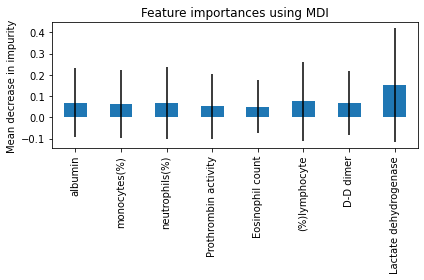

In [ ]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, 
                               index=list(X_train.columns))

std = std[forest_importances > 0.05]
forest_importances = forest_importances[forest_importances > 0.05]


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars.

As expected, the output suggests that not all features are informative.

In summary, this study has identified three indicators (LDH, hs-CRP and lymphocytes), together with a clinical route, for COVID-19 prognostic prediction.

## **Try running a different type of classifier and/or see how well you can do on the test set by tuning hyperparameters using cross-validation, grid search or otherwise.**

Random forest is just a collection of trees in which each of them gives a prediction and finally, we collect the outputs from all the trees and considers the mean, median, or mode of this collection as the prediction of this forest depending upon the nature of data (either continues or categorical). At a high level, this seems to be fine but there are high chances that most of the trees could have made predictions with some random chances since each of the trees had their own circumstances like class imbalance, sample duplication, overfitting, inappropriate node splitting, etc. (Aman Gupta)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = [{'criterion':['gini', 'entropy'], 
           'max_depth':[5,10,20,25,30]}]

rf = GridSearchCV(model,
                   params,
                   cv=3,
                   scoring="f1", 
                   return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, 20, 25, 30]}],
             return_train_score=True, scoring='f1')

In [ ]:
rf.best_params_

{'criterion': 'entropy', 'max_depth': 20}

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt,
                         X_train, y_train,
                         scoring="f1",
                         cv=3)
scores

array([0.93333333, 0.97435897, 0.96202532])

In [ ]:
y_test_hat = rf.predict(X_test)

In [ ]:
f1_score(y_test, y_test_hat, average=None)

array([0.97777778, 0.96666667])

Elapsed time to compute the importances: 0.017 seconds


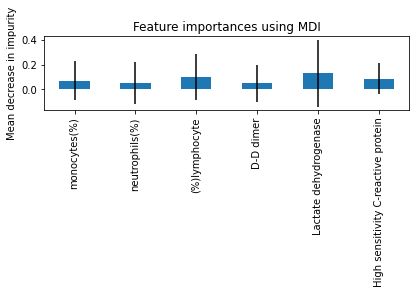

In [ ]:
start_time = time.time()
importances = rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, 
                               index=list(X_train.columns))

std = std[forest_importances > 0.05]
forest_importances = forest_importances[forest_importances > 0.05]


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

[...] machine learning tools selected three biomarkers that predict the mortality of individual patients more than 10 days in advance with more than 90% accuracy: **lactic dehydrogenase (LDH), lymphocyte and high-sensitivity C-reactive protein (hs-CRP).** In particular, relatively high levels of LDH alone seem to play a crucial role in distinguishing the vast majority of cases that require immediate medical attention. This finding is consistent with current medical knowledge that high LDH levels are associated with tissue breakdown occurring in various diseases, including pulmonary disorders such as pneumonia. [...]

Elapsed time to compute the importances: 0.011 seconds


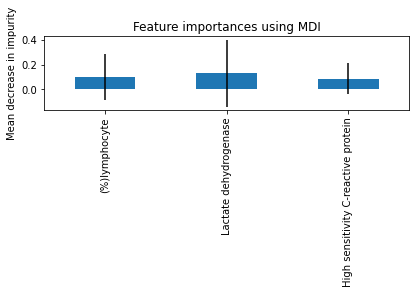

In [ ]:
start_time = time.time()
importances = rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, 
                               index=list(X_train.columns))

std = std[forest_importances > 0.08]
forest_importances = forest_importances[forest_importances > 0.08]


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
BaggingClassifier(DecisionTrees(splitter=”random”, max_leaf_nodes=None), n_estimators=100, max_samples=2.0, bootstrap=True, n_jobs=-1)

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
                                              *, 
                                              criterion='gini', 
                                              max_depth=None, 
                                              min_samples_split=2, 
                                              min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features='auto', 
                                              max_leaf_nodes=None, 
                                              min_impurity_decrease=0.0, 
                                              bootstrap=True, 
                                              oob_score=False, 
                                              n_jobs=None, 
                                              random_state=None, 
                                              verbose=0, 
                                              warm_start=False, 
                                              class_weight=None, 
                                              ccp_alpha=0.0, 
                                              max_samples=None)

Boosting happens to be iterative learning which means the model will predict something initially and self analyses its mistakes as a predictive toiler and give more weightage to the data points in which it made a wrong prediction in the next iteration. After the second iteration, it again self analyses its wrong predictions and gives more weightage to the data points which are predicted as wrong in the next iteration. This process continues as a cycle. Hence technically, if a prediction has been done, there is an at most surety that it did not happen as a random chance but with a thorough understanding and patterns in the data. Such a model that prevents the occurrences of predictions with a random chance is trustable most of the time. (Aman Gupta)

https://miro.medium.com/max/1400/1*6n0rqLRc8ljOsNlQ2Z5xug.png

https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30